# **GNNs Using Python: Chapter 03 - Node Embeddings: Word2Vec & DeepWalk**

*Author: Rafael Rodríguez Palomo*

*January, 2024*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python -m spacy download en_core_web_md

In [183]:
from gensim.models.word2vec import Word2Vec
import spacy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

## **Word2Vec Model**

Classic Word2Vec architecture, I only include an example because it is a well known architecture for me. Word2Vec is the basic component of DeepWalk architecture.

In [184]:
# Preprocessing is done with spaCy for some sentences
sentences = ['The rover and the helicopter began their missions at the Octavia E. Butler Landing site near the western rim of the 45 km',
             'The helicopter was intended to perform a 30-sol technology demonstration',
             'The development of the project that would eventually become Ingenuity started in 2012 when JPL director Charles Elachi toured and met with members of the Autonomous Systems Division at JPL',
             'At the time of the approval of the Mars 2020 program in July 2014, a helicopter flight demonstration was neither scoped nor budgeted',
             'The Ingenuity team was comparatively small, with never more than 65 full-time-equivalent employees from JPL. Program workers from AeroVironment, NASA AMES and Langley research centers brought the total to 150']

nlp = spacy.load('en_core_web_md')
lemmas = [[token.lemma_ for token in nlp(doc.lower()) if not token.is_punct and not token.is_stop and (token.is_alpha or token.is_digit)]
          for doc in sentences]

print(lemmas)

[['rover', 'helicopter', 'begin', 'mission', 'octavia', 'butler', 'landing', 'site', 'near', 'western', 'rim', '45', 'km'], ['helicopter', 'intend', 'perform', '30', 'sol', 'technology', 'demonstration'], ['development', 'project', 'eventually', 'ingenuity', 'start', '2012', 'jpl', 'director', 'charles', 'elachi', 'tour', 'meet', 'member', 'autonomous', 'system', 'division', 'jpl'], ['time', 'approval', 'mars', '2020', 'program', 'july', '2014', 'helicopter', 'flight', 'demonstration', 'scope', 'budget'], ['ingenuity', 'team', 'comparatively', 'small', '65', 'time', 'equivalent', 'employee', 'jpl', 'program', 'worker', 'aerovironment', 'nasa', 'ame', 'langley', 'research', 'center', 'bring', 'total', '150']]


In [185]:
model = Word2Vec(lemmas, vector_size=100, sg=1, window=5, min_count=0, epochs=40)
model.train(lemmas, total_examples=model.corpus_count, epochs=50, report_delay=1)
embeddings = model.wv.vectors

print(model.wv.vectors.shape)
print(f"Word embedding of word {lemmas[0][0]}: {model.wv[lemmas[0][0]]}")
words = list(model.wv.key_to_index.keys())

(61, 100)
Word embedding of word rover: [ 0.00054751 -0.00589926  0.00373622  0.00921333 -0.00168418 -0.00821279
 -0.00526322  0.01037488  0.00141596  0.00472341  0.00423174 -0.00663211
  0.00503546  0.01133018  0.01356677  0.00327201 -0.00628519 -0.01062542
  0.0063304  -0.01153653  0.00597043  0.00756582  0.00161881  0.00288702
 -0.00719847  0.00400004  0.00058894  0.00224024 -0.01205277  0.00776053
  0.01348689 -0.00397211  0.00972505 -0.00168439 -0.00318807  0.00884109
 -0.00567498  0.00131091 -0.00305972 -0.00693194 -0.00234428 -0.00872968
  0.00591837  0.00798062  0.00569905  0.00025435 -0.00674333  0.00260333
 -0.00489486 -0.00194611  0.01362436  0.00447054 -0.00748713 -0.0086862
  0.01039456  0.00184647  0.01081094 -0.00515464 -0.00462408 -0.00098697
 -0.00053233 -0.00186433 -0.00257626  0.00703501 -0.0084278   0.01364111
 -0.00534908  0.0123807  -0.00959708  0.01071121 -0.00915398 -0.00521409
  0.00667728 -0.0032549   0.01805636 -0.00021871 -0.00614187  0.00968213
 -0.00076078

To visualize the embedding we run a T-SNE over the word embeddings, note that the training set is quite scarce so we do not expect very good results.

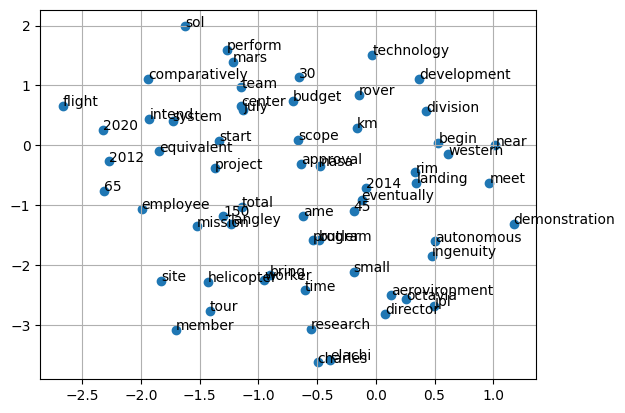

In [186]:
tsne = TSNE(n_components=2)
embed_2d = tsne.fit_transform(embeddings)

x = embed_2d[:,0]
y = embed_2d[:,1]

plt.scatter(x, y)
for i, txt in enumerate(words):
    plt.text(x[i], y[i], txt, fontsize=10)

plt.grid()
plt.show()

## **DeepWalk and Random Walks**

Node embedding method proposed in 2014 whose goal is to produce high-quality representations of nodes in a supervised manner to translate **topolodical information**  into tabular data.

It is based on Word2Vec model so it creates the reprsentations by means of random walks (randomly choosing a neighboring node in every step) to generate meaningful sequences of nodes that act like sentences, then, these "sentences" are translated into embeddings using the Word2Vec model.

The **network homophily** theory states that nodes that appear close to each other are similar. Thus, with DeepWalk we want to obtain high similarity scores with nodes that are closed together and low similarity scores if the are far appart.

### Random Walks

The basic operation of the DeepWalk model is the random walk. Given a graph we can generate a random walk by randomly choosing a neihgboring node at every step.

Nodes that appear next to each other in the random walk are prone to be similar if the graph is homphilic.

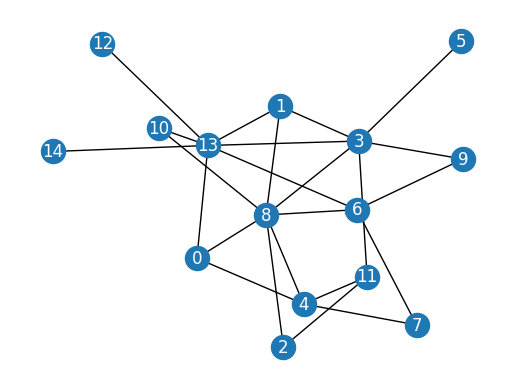

In [187]:
G = nx.erdos_renyi_graph(n=15, p=0.35, seed=0)

plt.axis('off')
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), font_size=12, font_color='white')

We implement our own random walk generator.

In [188]:
def random_walk(start_node, graph, elements):
  walk = [str(start_node)]
  node = start_node

  for i in range(elements):
    neighbors = list(graph.neighbors(node))
    chosen = np.random.choice(neighbors, 1)[0]
    walk.append(str(chosen))
    node = chosen

  return walk

In [189]:
walk = random_walk(start_node=0, graph=G, elements=15)
print(walk)

['0', '4', '7', '4', '0', '8', '10', '8', '6', '9', '6', '13', '12', '13', '0', '8']


### Implementing DeepWalk

We are going to implement it using an example based on the well known Karate Club dataset. The goal is to create representative node embeddings to later perform classification with a simple ML model.

In [190]:
# Extract labels and print graph
karate_graph = nx.karate_club_graph()
labels = [1 if karate_graph.nodes[node]['club'] == 'Officer' else 0 for node in karate_graph.nodes]

print(f"Number of Club 1 members: {np.sum(labels)}")
print(f"Number of Club 2 members: {len(labels) - np.sum(labels)}")

Number of Club 1 members: 17
Number of Club 2 members: 17


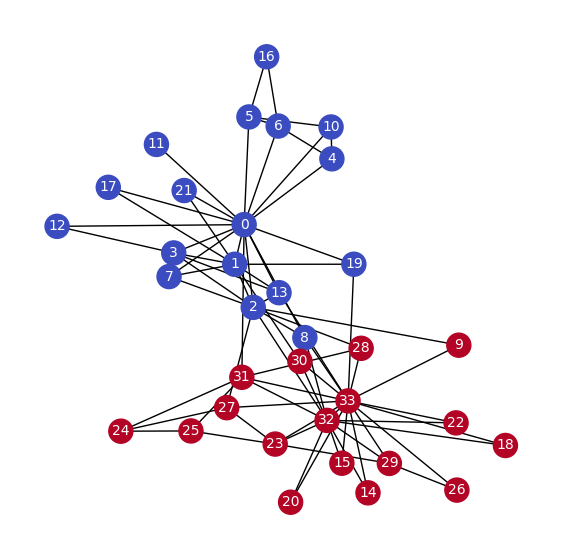

In [191]:
plt.figure(figsize=(7, 7))
plt.axis('off')
nx.draw_networkx(karate_graph, pos=nx.spring_layout(karate_graph, seed=0), cmap='coolwarm',
                 node_color=labels, font_size=10, font_color='white')

Now we create our dataset using the random walk function defined above. To do so we generate $80$ random walks with $10$ nodes per walk for every node in the graph.

In [192]:
n_walks = 100
n_elements = 10
walks = [random_walk(node, karate_graph, n_elements) for node in karate_graph.nodes for i in range(n_walks)]

# Print an example
print(f"Total number of walks: {len(walks)}")
print(walks[0])
print(walks[1])

Total number of walks: 3400
['0', '6', '16', '5', '6', '16', '6', '5', '10', '0', '13']
['0', '2', '7', '1', '3', '2', '9', '33', '32', '31', '25']


One we have created our training set we can infer the node embeddings using the Word2Vec model.

In [193]:
model = Word2Vec(walks, sg=1, window=3, vector_size=100, seed=0)
model.train(walks, total_examples=model.corpus_count, epochs=50, report_delay=1) # Train Word2Vec
node_order = list(model.wv.key_to_index.keys()) # Extract labels

node_embeddings = model.wv.vectors
print(node_embeddings.shape)
print(f'Embedding for node 0: {model.wv[str(0)]}')

(34, 100)
Embedding for node 0: [ 0.03629375  0.11516568  0.02985135 -0.02953907  0.19690579  0.14740695
 -0.23006243 -0.30581886  0.10311643 -0.04157865 -0.15109749 -0.11655073
  0.23172016 -0.14119184  0.21362571  0.16884792  0.09917726  0.09418209
  0.04759772 -0.17924187  0.04287304  0.07480957 -0.01115421 -0.09282887
  0.36627227  0.03834525  0.21019022  0.03382706  0.09939539 -0.24821457
  0.15952341 -0.06767842  0.1571479  -0.21053766 -0.06116466  0.15353969
 -0.03804766 -0.0998219   0.13014084 -0.12394475  0.00998872 -0.03839958
  0.10665933  0.03423451 -0.00840353 -0.0642547  -0.03955149  0.02387656
 -0.13093203 -0.00906547 -0.13166234 -0.0843676   0.225314    0.1745143
  0.10971978  0.33801565  0.05920548  0.04848575 -0.11582139  0.11378367
  0.10808823  0.3310009   0.06181723  0.18810883 -0.01766376  0.12082669
  0.06592178 -0.00616799  0.16709816 -0.0771075  -0.12008385  0.00448018
 -0.04501814  0.07665742  0.07238553 -0.01349035 -0.06773593 -0.20626734
 -0.17848952  0.3406

In [194]:
node = 0
print(f"Most similar nodes to node {node}: {model.wv.most_similar(str(node))}")

Most similar nodes to node 0: [('6', 0.6790362000465393), ('4', 0.6777689456939697), ('10', 0.6672400236129761), ('5', 0.6426758170127869), ('16', 0.6203433275222778), ('21', 0.5893908143043518), ('11', 0.5831664800643921), ('17', 0.5705747604370117), ('12', 0.551633358001709), ('7', 0.5327370166778564)]


Again, we run a T-SNE over the embeddings to see how the embedding space is organized.

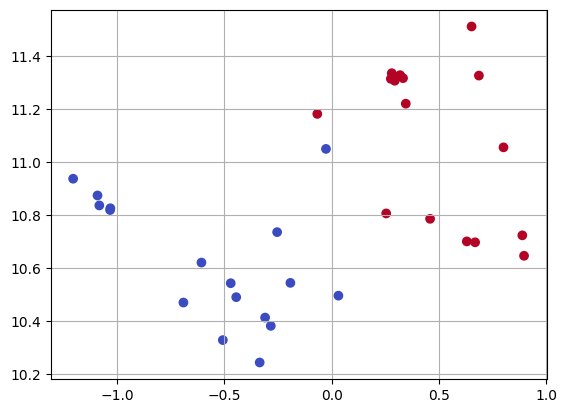

In [195]:
tsne = TSNE(n_components=2)
node_embed_2d = tsne.fit_transform(node_embeddings)

labels_arr = np.array([labels[int(node)] for node in node_order])
plt.scatter(node_embed_2d[:,0], node_embed_2d[:,1], c=labels_arr, cmap='coolwarm')
plt.grid()
plt.show()

### Node Classification

From the previous plot it is easy to extract that with a pretty simple classifier like a KNN we can perform a pretty accurate classification of the nodes.

Note that in this simple example we are not considering a separation between the test and training sets.

Best number of neighbors: {'n_neighbors': 2}
Top accuracy: 0.9705882352941176
AUC score: 0.9982698961937716


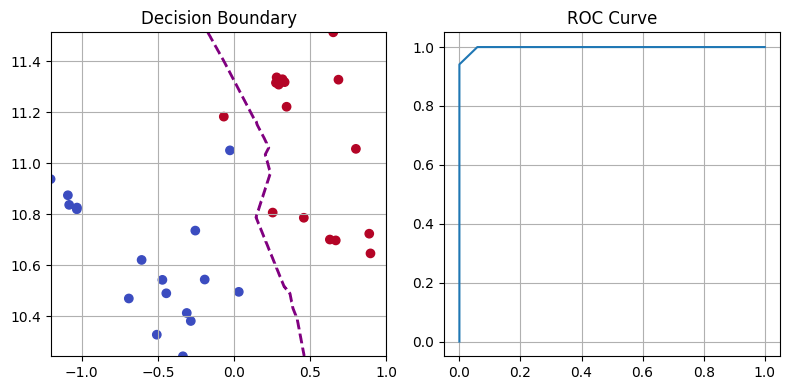

In [197]:
# Params
kfolds = 5
parameters = {'n_neighbors': np.arange(2, 10, 1)}

# Cross Validation
clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=kfolds, scoring='accuracy')
clf.fit(node_embed_2d, labels_arr)

# Evaluation
proba = clf.predict_proba(node_embed_2d)
fpr, tpr, _ = roc_curve(labels_arr, proba[:,1])
auc = roc_auc_score(labels_arr, proba[:,1])

x_min, x_max = np.min(node_embed_2d[:,0]), np.max(node_embed_2d[:,0])
y_min, y_max = np.min(node_embed_2d[:,1]), np.max(node_embed_2d[:,1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001), np.arange(y_min, y_max, 0.001))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

print(f"Best number of neighbors: {clf.best_params_}")
print(f"Top accuracy: {clf.score(node_embed_2d, labels_arr)}")
print(f"AUC score: {auc}")

fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout='tight')
axes[0].contour(xx, yy, Z, levels=[0.5], colors='purple', linewidths=2, linestyles='dashed')
axes[0].scatter(node_embed_2d[:,0], node_embed_2d[:,1], c=labels_arr, cmap='coolwarm')
axes[0].set_title('Decision Boundary')
axes[0].grid()
axes[1].plot(fpr, tpr)
axes[1].set_title('ROC Curve')
axes[1].grid()